In [1]:
!pip install numpy scipy faiss-cpu matplotlib

In [2]:
import numpy as np
from scipy import spatial 
import faiss
import typing
from time import time
import matplotlib.pyplot as plt
import time

## Helper Function

In [3]:
def generate_vectors(
        num_vectors: int,
        dim: int,
        distribution: str,
        seed: int = 42,
) -> np.ndarray:
    """
    This function generates random vectors of uniform distribution.
    Args:
        num_vectors: The number of vectors to generate.
        dim: The dimensionality of the vectors.
        seed: The random seed.
    Returns:
        An array of shape (num_vectors, dim) containing the generated vectors.
    """
    np.random.seed(seed)
    return np.random.uniform(0, 1, (num_vectors, dim))

In [4]:
def naive_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray, 
        k: int,
) -> np.ndarray:
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the naive exhaustive approach.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    all_distances = []
    for query_vector in query_vectors:
        query_distances = []
        for index_vector in index_vectors:
            query_distances.append(spatial.distance.euclidean(query_vector, index_vector))
        all_distances.append(np.argsort(query_distances)[:k])
    return np.array(all_distances)

In [5]:
def optimized_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
):
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the optimized exhaustive approach implemented in SciPy.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances = spatial.distance.cdist(query_vectors, index_vectors, 'euclidean')
    return np.argsort(distances, axis=1)[:, :k]

In [6]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [7]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [8]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [9]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 1.1 - Running Time Comparison

You are given three methods for vector search:
<ol>
 <li> naive_exhaustive_search </li> 
 <li> optimized_exhaustive_search </li> 
 <li> faiss_flatL2 </li> 
</ol>

each one implements vector search with different levels of optimization. Your task is to compare the running time of these three methods. 
You need to complete the code so that the generated plots should reflect the increasing difference in running time between the methods, as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.

### Generate the following plots:
##### 1.1.1. Running time of the three methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
##### 1.1.2. Running time of the three methods as a function of the dimensionality of the vectors (x-axis) with the following parameters fixed:
* number of vectors in the index: 100000
* number of vectors in the query set: 1000

In [12]:
VECTOR_DIM=100
NUM__QUERY_VECTORS111=1000
K=10

In [11]:
def calc_time(query_vectors,index_vectors,func):
    """
    This function calculates the time difference for activating func
    Args:
        query_vectors: The query vectors.
        index_vectors: The index vectors.
        func: a given function.
    Returns:
        The time difference.
    """
    start_time =time.time()
    func(query_vectors,index_vectors,K)
    end_time =time.time()
    return end_time-start_time

In [12]:
#TODO: Write your code for 1.1.1 here
num_index_vectors=range(2000,20001,2000)
#generate query vectors
query_vectors = generate_vectors(NUM__QUERY_VECTORS111,VECTOR_DIM,"")
naive_times111=[]
optimized_times111=[]
faiss_flatL2_times111=[]
#for each amount of index vectors in the index calculate time difference for the different search methods
for i in num_index_vectors:
    print(i)
    index_vectors = generate_vectors(i,VECTOR_DIM,"")
    naive_times111.append(calc_time(query_vectors,index_vectors,naive_exhaustive_search))
    optimized_times111.append(calc_time(query_vectors,index_vectors,optimized_exhaustive_search))
    faiss_index = build_faiss_flatl2_index(index_vectors,VECTOR_DIM)
    faiss_flatL2_times111.append(calc_time(query_vectors,faiss_index,faiss_search))

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000


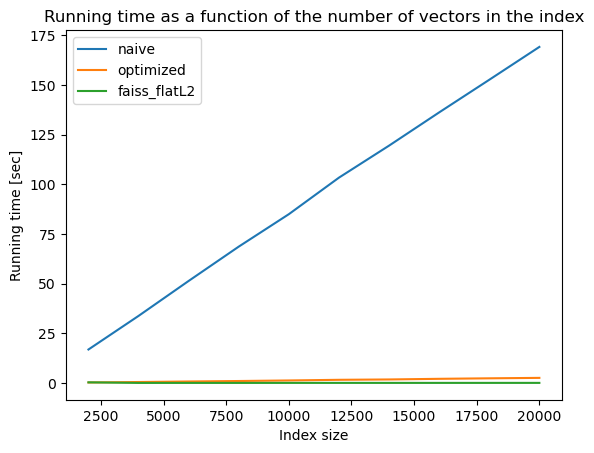

In [14]:
#plotting
plt.plot(num_index_vectors,naive_times111,label='naive')
plt.plot(num_index_vectors,optimized_times111,label='optimized')
plt.plot(num_index_vectors,faiss_flatL2_times111,label='faiss_flatL2')
plt.legend()
plt.title("Running time as a function of the number of vectors in the index")
plt.xlabel("Index size")
plt.ylabel("Running time [sec]")
plt.show()

In [17]:
NUM__INDEX_VECTORS112=100000
NUM__QUERY_VECTORS112=100

In [18]:
#TODO Write your code for 1.1.2 here
vectorDims=range(10,101,10)
#naive_times=[]
optimized_times112=[]
faiss_flatL2_times112=[]
#for each size of index vectors in the index calculate time difference for the different search methods
for i in vectorDims:
    print(i)
    query_vectors = generate_vectors(NUM__QUERY_VECTORS112,i,"")
    index_vectors = generate_vectors(NUM__INDEX_VECTORS112,i,"")
    #naive_times.append(calc_time(query_vectors,index_vectors,naive_exhaustive_search))
    optimized_times112.append(calc_time(query_vectors,index_vectors,optimized_exhaustive_search))
    faiss_index = build_faiss_flatl2_index(index_vectors,i)
    faiss_flatL2_times112.append(calc_time(query_vectors,faiss_index,faiss_search))

10
20
30
40
50
60
70
80
90
100


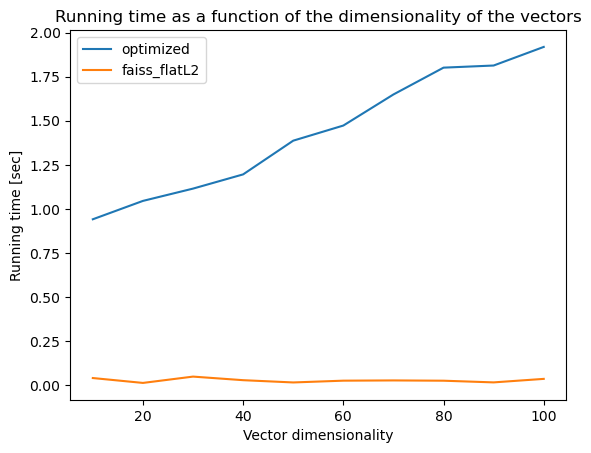

In [19]:
#plotting
plt.plot(vectorDims,optimized_times112,label='optimized')
plt.plot(vectorDims,faiss_flatL2_times112,label='faiss_flatL2')
plt.legend()
plt.title("Running time as a function of the dimensionality of the vectors")
plt.xlabel("Vector dimensionality")
plt.ylabel("Running time [sec]")
plt.show()

# 1.2 -- Faiss LSH
### Create the following plots:
##### 1.2.1. Running time of Faiss LSH as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* nbits: 500

##### 1.2.2. Running time of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000


##### 1.2.3. recall@k of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000
* k: 10


You need to complete the code so that the generated plots should reflect the desired metrics as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.


In [20]:
#TODO: Write your code for 1.2.1 here
NUM__QUERY_VECTORS121=1000
NBITS=500
num__index_vectors=range(5000,100001,5000)
query_vectors = generate_vectors(NUM__QUERY_VECTORS121,VECTOR_DIM,"")
faiss_lsh_times121=[]
#for each amount of index vectors in the index calculate time difference for the faiss lsh search method
for i in num__index_vectors:
    print(i)
    index_vectors = generate_vectors(i,VECTOR_DIM,"")
    faiss_index121 = build_faiss_lsh_index(index_vectors,VECTOR_DIM,NBITS)
    faiss_lsh_times121.append(calc_time(query_vectors,faiss_index121,faiss_search))

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000


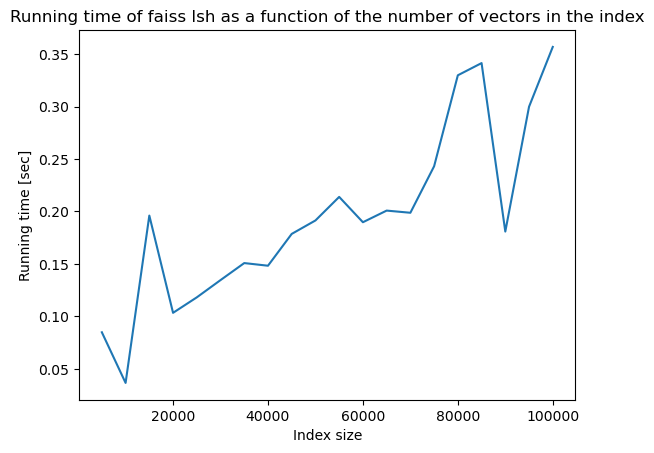

In [21]:
#plotting
plt.plot(num__index_vectors,faiss_lsh_times121)
plt.title("Running time of faiss lsh as a function of the number of vectors in the index")
plt.xlabel("Index size")
plt.ylabel("Running time [sec]")
plt.show()

In [22]:
#TODO: Write your code for 1.2.2 here
NUM__QUERY_VECTORS122=1000
NUM__INDEX_VECTORS122=500000
n_bits=range(100,2001,100)
query_vectors = generate_vectors(NUM__QUERY_VECTORS122,VECTOR_DIM,"")
faiss_lsh_times122=[]
#for each amount of nbits used in the index calculate time difference for the faiss lsh search method
for i in n_bits:
    print(i)
    index_vectors = generate_vectors(NUM__INDEX_VECTORS122,VECTOR_DIM,"")
    faiss_index122 = build_faiss_lsh_index(index_vectors,VECTOR_DIM,i)
    faiss_lsh_times122.append(calc_time(query_vectors,faiss_index122,faiss_search))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


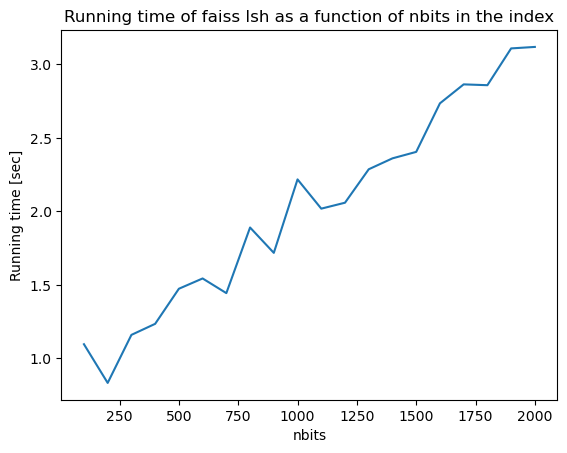

In [23]:
#plotting
plt.plot(n_bits,faiss_lsh_times122)
plt.title("Running time of faiss lsh as a function of nbits in the index")
plt.xlabel("nbits")
plt.ylabel("Running time [sec]")
plt.show()

In [13]:
#TODO: Write your code for 1.2.3 here
NUM__QUERY_VECTORS123=100
NUM__INDEX_VECTORS123=100000
K123=10
n_bits123=range(100,2001,100)
query_vectors = generate_vectors(NUM__QUERY_VECTORS123,VECTOR_DIM,"")
faiss_lsh_recall_at_k_123=[]
#for each amount of nbits used in the index calculate Recall@k for the faiss lsh search method
for i in n_bits123:
    print(i)
    index_vectors = generate_vectors(NUM__INDEX_VECTORS123,VECTOR_DIM,"")
    faiss_index123 = build_faiss_lsh_index(index_vectors,VECTOR_DIM,i)
    faiss_lsh_prediction=faiss_search(query_vectors,faiss_index123,K123)
    ground_truth=optimized_exhaustive_search(query_vectors,index_vectors,K123)
    #calculate recall@k by comparing to the ground truth
    faiss_lsh_recall_at_k_123.append(compute_recall_at_k(ground_truth,faiss_lsh_prediction,K123))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


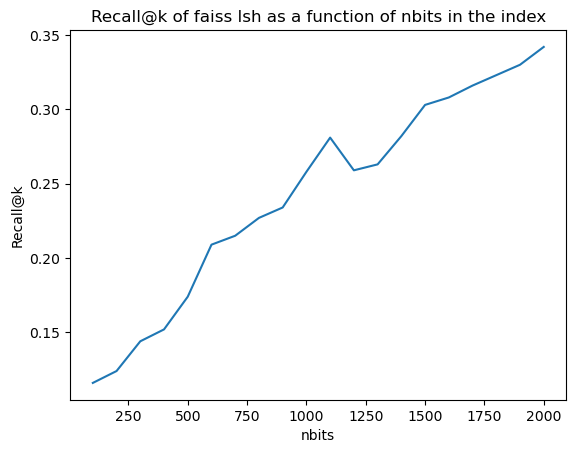

In [14]:
#plotting
plt.plot(n_bits123,faiss_lsh_recall_at_k_123)
plt.title("Recall@k of faiss lsh as a function of nbits in the index")
plt.xlabel("nbits")
plt.ylabel("Recall@k")
plt.show()